In this tutorial we are going to cover the following:

1) Create generators for two timbres, specifically sine and square waves. Square will be implemented "the wrong way", i.e. it will not prevent the formation of aliasing artifacts.

2) We are going to use some basic tools for visualising spectrum and observe aliasing.

3) We are going to make a correct version of square, i.e., that prevents aliasing.

4) We are going to make a class-based implementation of these two generators.

As an exercise, you'll have to add triangle and sawtooth waveforms (with the correct, aliasing-preventing way) to the class implementation.

In [3]:
import numpy as np
# simple sine wave function
def make_sine( freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100 ):
    # phase is multiples of 2*pi
    t = np.arange(dur_secs*sr)/sr
    return amp*np.sin( 2*np.pi*freq*t + np.pi*2*phase )

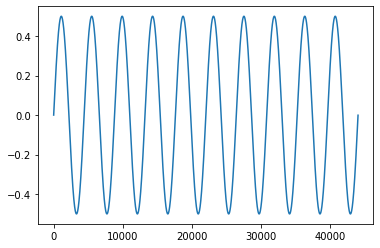

In [13]:
import matplotlib.pyplot as plt
# Let's visualise 1 second of a sine wave with a low frequency of 10Hz
sine = make_sine(freq=10, dur_secs=1)
plt.plot( sine )

In [17]:
# simple square wave function - wrong function, since it does not prevent aliasing!
def make_square_aliased( freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100 ):
    t = np.arange(dur_secs*sr)/sr
    return -amp*( 1 - 2*( ( np.sin( 2*np.pi*freq*t + np.pi*2*phase ) > 0 ).astype(float) ) )

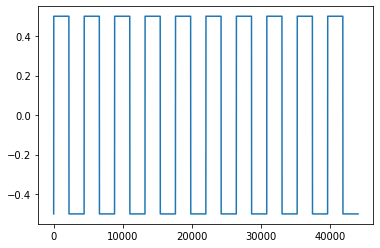

In [18]:
import matplotlib.pyplot as plt
# Let's visualise 1 second of a sine wave with a low frequency of 10Hz
square = make_square_aliased(freq=10, dur_secs=1)
plt.plot( square )

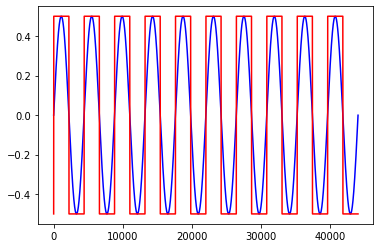

In [19]:
# Let's visualise sine and square together, to understand the construction process
plt.plot(sine, 'b')
plt.plot(square, 'r')

In [32]:
# Introduce a function for plotting the n first samples of a signal
def compute_power_spectrum(s, n=2048):
    if len(s) < n:
        print('length of signal is smaller than requested window size')
        return -1
    # apply hanning window in the first m samples
    w = np.hanning(n)
    s_windowed = w*s[:n]
    # apply fft to the windowed signal
    s_fft = np.fft.fft(s_windowed)
    mag = np.sqrt( np.power( s_fft.real , 2 ) + np.power( s_fft.imag , 2 ) )
    return mag[:len(mag)//2]

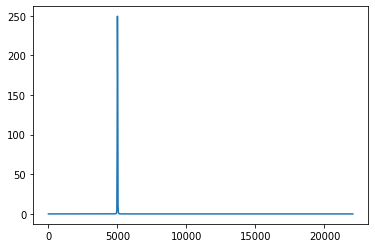

In [33]:
# We need to increase the frequency for clearer visualisation in the frequency domain
# Let's start with the sine wave
sine = make_sine(freq=5000, dur_secs=1)
# get power spectrum
sine_power_spectrum = compute_power_spectrum(sine)
# and plot it
plt.plot( np.linspace(0,22050, num=len(sine_power_spectrum)) , sine_power_spectrum )

For the square wave we are expecting to see peaks at odd harmonics, i.e. 5000\*3, 5000\*5, etc. Since the Nyquist frequency is 22050, we would expect to not see frequencies beyond there, i.e., only 5000\*3=1500 should be there, since every other odd harmonic is beyond 25000 (=5000\*5).

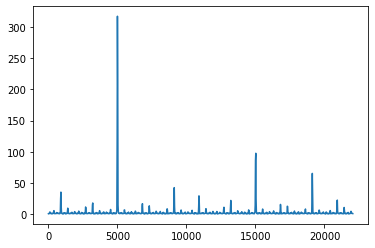

In [34]:
# Let's do the same with the "wrong" square
square = make_square_aliased(freq=5000, dur_secs=1)
# get power spectrum
square_power_spectrum = compute_power_spectrum(square)
# ... but see what we get when plotting
plt.plot( np.linspace(0,22050, num=len(square_power_spectrum)) , square_power_spectrum )

In the above diagram, we see the aliasing effect. Specificall, the 15000Hz peak is correctly there, but all other peaks should not be there. For example, the third highest peak, which appears a bit below 20000Hz, is the aliased form of 25000. Specifically, the frequency value of this peak is#

22050 - (25000 - 22050) = 22050 - 2950 = 19100.

To solve this aliasing issue, we need to construct a generator that composes each harmonic component separately, with their respective amplitudes, up the harmonic that can be afforded by the Nyquist frequency.

In [35]:
# The correct implementation of square wave that prevents aliasing.
def make_square( freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100 ):
    t = np.arange(dur_secs*sr)/sr
    s = np.sin( 2*np.pi*freq*t )
    i = 3
    freq_harmonics = freq*i
    while freq_harmonics <= sr/2:
        s += (1/i)*np.sin( 2*np.pi*freq_harmonics*t )
        i += 2
        freq_harmonics = freq*i
    return amp*s

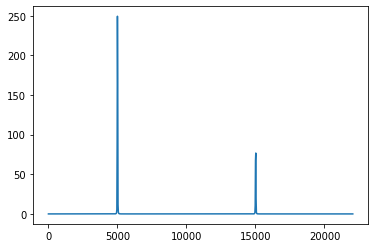

In [36]:
# test it
square_correct = make_square(freq=5000, dur_secs=1)
# get power spectrum
square_power_spectrum = compute_power_spectrum(square_correct)
# ... but see what we get when plotting
plt.plot( np.linspace(0,22050, num=len(square_power_spectrum)) , square_power_spectrum )

In [46]:
# Let's make a class that knows how to do all of the above
class WaveGenerator:
    def __init__(self, type='sine', freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100):
        self.type = type
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.dur_secs = dur_secs
        self.sr = sr
        self.assign_generator_function()
    # end constructor
    def assign_generator_function(self):
        if self.type == 'sine':
            self.generator_function = self.make_sine
        elif self.type == 'square':
            self.generator_function = self.make_square
    # end assign_generator_function
    def make_sine( self, freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100 ):
        # phase is multiples of 2*pi
        t = np.arange(self.dur_secs*self.sr)/self.sr
        return self.amp*np.sin( 2*np.pi*self.freq*t + np.pi*2*self.phase )
    # end make_sine
    def make_square( self, freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100 ):
        t = np.arange(self.dur_secs*sr)/self.sr
        s = np.sin( 2*np.pi*self.freq*t )
        i = 3
        freq_harmonics = self.freq*i
        while freq_harmonics <= self.sr/2:
            s += (1/i)*np.sin( 2*np.pi*freq_harmonics*t )
            i += 2
            freq_harmonics = self.freq*i
        return self.amp*s
    # end make_square
    def make_sound(self, freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100):
        return self.generator_function(freq=440 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100)
    # end make_sound
    def compute_power_spectrum(self, s, n=2048):
        if len(s) < n:
            print('length of signal is smaller than requested window size')
            return -1
        # apply hanning window in the first m samples
        w = np.hanning(n)
        s_windowed = w*s[:n]
        # apply fft to the windowed signal
        s_fft = np.fft.fft(s_windowed)
        mag = np.sqrt( np.power( s_fft.real , 2 ) + np.power( s_fft.imag , 2 ) )
        return mag[:len(mag)//2]
    def plot_power_spectrum(self, freq=5000 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100, window_size=2048):
        s = self.generator_function( freq=5000 , amp=0.5 , phase=0.0 , dur_secs=0.5 , sr=44100 )
        n = window_size
        if len(s) < n:
            print('length of signal is smaller than requested window size')
            return -1
        # apply hanning window in the first m samples
        w = np.hanning(n)
        s_windowed = w*s[:n]
        # apply fft to the windowed signal
        s_fft = np.fft.fft(s_windowed)
        mag = np.sqrt( np.power( s_fft.real , 2 ) + np.power( s_fft.imag , 2 ) )
        power_spectrum = mag[:len(mag)//2]
        plt.plot( np.linspace(0,self.sr//2, num=len(power_spectrum)) , power_spectrum )
    # end plot_power_spectrum
# end WaveGenerator

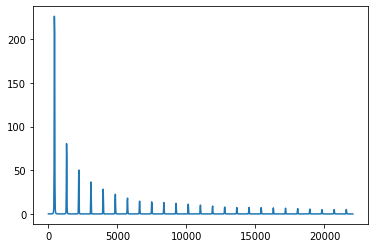

In [48]:
# test the class
w = WaveGenerator('square')
s = w.plot_power_spectrum(freq=1500)